In [1]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import random

%matplotlib inline

device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# tratamento da seed - pytorch
def set_seed(seed: int, deterministic_torch: bool = True):
    random.seed(seed) # Python
    np.random.seed(seed)  # Numpy, é o gerador utilizado pelo sklearn
    os.environ["PYTHONHASHSEED"] = str(seed)  # sistema operativo
    if torch is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  #multi-GPU
        if deterministic_torch:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

set_seed(25)

In [3]:
df = pd.read_csv("../sbsppdaa24/train_radiomics_hipocamp.csv")

In [4]:
df.head()

,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition
0,006_S_0681,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.007881,345733.167092,479.414935,0.001538,0.183049,0.017044,0.001581,0,77.1,CN-CN
1,941_S_1203,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.013112,244310.331892,378.001763,0.001761,0.146021,0.010782,0.001813,1,83.4,CN-CN
2,011_S_0003,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.011331,222776.529605,497.261162,0.001567,0.190309,0.019644,0.001596,1,81.3,AD-AD
3,057_S_0779,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.012197,280222.663268,406.837667,0.001629,0.148247,0.010824,0.001677,1,79.6,CN-MCI
4,033_S_0920,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.010859,216779.591479,368.838125,0.001912,0.174701,0.014793,0.001979,0,80.1,CN-CN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2181 entries, ID to Transition
dtypes: float64(2014), int64(147), object(20)
memory usage: 5.1+ MB


Impute by mean the *Nan* values of *Age*

In [6]:
df.isnull().sum()

ID                                  0
Image                               0
Mask                                0
diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
                                   ..
lbp-3D-k_ngtdm_Contrast             0
lbp-3D-k_ngtdm_Strength             0
Sex                                 0
Age                                 0
Transition                          0
Length: 2181, dtype: int64

In [7]:
# Drop unique identifier columns
df.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Drop non-numeric columns except for 'Transition'
columns_to_drop = [col for col in df.columns if df[col].dtype == 'object' and col != 'Transition']
df.drop(columns=columns_to_drop, inplace=True)

# Apply MinMax scaling to columns
from sklearn.preprocessing import MinMaxScaler
float_cols = df.select_dtypes(include=['float', 'int']).columns
scaler = MinMaxScaler()
df[float_cols] = scaler.fit_transform(df[float_cols])

df.head()

,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition
0,0.0,0.468027,0.0,0.393701,0.598392,0.0,0.555087,0.455539,0.392720,0.289560,...,0.184251,0.633393,0.646173,0.125643,0.735632,0.658619,0.127238,0.0,0.610644,CN-CN
1,0.0,0.281221,0.0,0.488189,0.713552,0.0,0.588970,0.397306,0.338081,0.311579,...,0.651481,0.323882,0.458297,0.195642,0.492265,0.373790,0.198729,1.0,0.787115,CN-CN
2,0.0,0.764980,0.0,0.212598,0.530116,0.0,0.727218,0.876712,1.000000,0.431089,...,0.492440,0.258168,0.679235,0.134842,0.783349,0.776907,0.132002,1.0,0.728291,AD-AD
3,0.0,0.651078,0.0,0.338583,0.799452,0.0,0.547963,0.355153,0.372946,0.453707,...,0.569706,0.433476,0.511718,0.154368,0.506896,0.375681,0.156912,1.0,0.680672,CN-MCI
4,0.0,0.382225,0.0,0.173228,0.406742,0.0,0.504096,0.080905,0.078060,0.545945,...,0.450216,0.239867,0.441321,0.243251,0.680762,0.556234,0.249892,0.0,0.694678,CN-CN


In [8]:
from sklearn.preprocessing import LabelEncoder

cols = ['Transition']
le = LabelEncoder()

for col in cols:
    df[col] = le.fit_transform(df[col])
df.head()

,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition
0,0.0,0.468027,0.0,0.393701,0.598392,0.0,0.555087,0.455539,0.392720,0.289560,...,0.184251,0.633393,0.646173,0.125643,0.735632,0.658619,0.127238,0.0,0.610644,1
1,0.0,0.281221,0.0,0.488189,0.713552,0.0,0.588970,0.397306,0.338081,0.311579,...,0.651481,0.323882,0.458297,0.195642,0.492265,0.373790,0.198729,1.0,0.787115,1
2,0.0,0.764980,0.0,0.212598,0.530116,0.0,0.727218,0.876712,1.000000,0.431089,...,0.492440,0.258168,0.679235,0.134842,0.783349,0.776907,0.132002,1.0,0.728291,0
3,0.0,0.651078,0.0,0.338583,0.799452,0.0,0.547963,0.355153,0.372946,0.453707,...,0.569706,0.433476,0.511718,0.154368,0.506896,0.375681,0.156912,1.0,0.680672,2
4,0.0,0.382225,0.0,0.173228,0.406742,0.0,0.504096,0.080905,0.078060,0.545945,...,0.450216,0.239867,0.441321,0.243251,0.680762,0.556234,0.249892,0.0,0.694678,1


In [9]:
df['Transition'].nunique()

5

In [10]:
(df['Transition'] == 0).sum()

60

In [11]:
(df['Transition'] == 1).sum()

96

In [12]:
(df['Transition'] == 2).sum()

10

In [13]:
(df['Transition'] == 3).sum()

68

In [14]:
(df['Transition'] == 4).sum()

71

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2162 entries, diagnostics_Image-original_Dimensionality to Transition
dtypes: float64(2161), int64(1)
memory usage: 5.0 MB


In [16]:
# Loop para verificar se todas as colunas têm valores iguais
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"A coluna '{column}' tem todos os valores iguais.")

A coluna 'diagnostics_Image-original_Dimensionality' tem todos os valores iguais.
A coluna 'diagnostics_Image-original_Minimum' tem todos os valores iguais.
A coluna 'diagnostics_Mask-original_VolumeNum' tem todos os valores iguais.
A coluna 'lbp-2D_firstorder_Entropy' tem todos os valores iguais.
A coluna 'lbp-2D_firstorder_Maximum' tem todos os valores iguais.
A coluna 'lbp-2D_firstorder_Minimum' tem todos os valores iguais.
A coluna 'lbp-2D_firstorder_Range' tem todos os valores iguais.
A coluna 'lbp-2D_firstorder_Uniformity' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_Autocorrelation' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_ClusterProminence' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_ClusterShade' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_ClusterTendency' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_Contrast' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_Correlation' tem todos os valores iguais.
A coluna 'lbp-2D_glcm_DifferenceAverage'

In [17]:
df = df.loc[:, df.nunique() > 1]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2014 entries, diagnostics_Image-original_Mean to Transition
dtypes: float64(2013), int64(1)
memory usage: 4.7 MB


In [19]:
# Separando variáveis
df_X = df.drop(columns=['Transition'])
df_y = df['Transition']

In [20]:
t_X = pd.DataFrame(df_X)
filename = "train_nn2.csv"
t_X.to_csv(filename, index=False, encoding='utf-8')

In [21]:
t_y = pd.DataFrame(df_y)
filename = "res_nn2.csv"
t_y.to_csv(filename, index=False, encoding='utf-8')

In [22]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor

# Classe personalizada para carregar o dataset a partir de arquivos CSV
class CSVDataset(Dataset):
    def __init__(self, path):
        # Lê o arquivo CSV que contém as features (entradas)
        df_X = pd.read_csv("train_nn2.csv", header=0)  # Carrega o arquivo de treino (features)
        
        # Lê o arquivo CSV que contém os rótulos (saídas/targets)
        df_y = pd.read_csv("res_nn2.csv", header=0)  # Carrega o arquivo de resultado
        
        # Converte os dados de features (entradas) para um array numpy
        self.X = df_X.values
        
        # Converte os dados de rótulos para um array numpy e ajusta os valores (subtrai 1)
        self.y = df_y.values[:, 0]  
        
        # Converte os dados de features para o tipo 'float64' (precisão para modelos de ML)
        self.X = self.X.astype('float32')
        
        # Converte os rótulos para tensores do PyTorch (com tipo 'long' para inteiros)
        self.y = torch.tensor(self.y, dtype=torch.long, device=device)
        
        # Imprime as dimensões e o tipo de dado dos arrays para debugging
        print(self.X.shape)  # Exibe a forma do array de features
        print(self.y.shape)  # Exibe a forma do array de rótulos
        print(self.X.ndim)   # Exibe o número de dimensões do array de features
        print(self.y.ndim)   # Exibe o número de dimensões do array de rótulos
        print(self.X.dtype)  # Exibe o tipo de dado dos features
        print(self.y.dtype)  # Exibe o tipo de dado dos rótulos
        
    # Método que retorna o número total de amostras no dataset
    def __len__(self):
        return len(self.X)  # Retorna o número de exemplos no dataset (tamanho de X)
    
    # Método que retorna uma amostra do dataset (um par [feature, rótulo]) dado um índice
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]  # Retorna a feature e o rótulo correspondente ao índice 'idx'
    
    # Método para dividir o dataset em subconjuntos de treino e teste
    def get_splits(self, n_test):
        test_size = round(n_test * len(self.X))  # Define o tamanho do conjunto de teste (com base na fração n_test)
        train_size = len(self.X) - test_size  # O restante dos dados será usado para treino
        return random_split(self, [train_size, test_size])  # Divide o dataset em treino e teste

# Função para preparar os dados, carregando o dataset e criando os DataLoaders
def prepare_data(df, n_test):
    dataset = CSVDataset(df)  # Cria uma instância do dataset a partir do arquivo CSV
    
    # Divide o dataset em treino e teste
    train, test = dataset.get_splits(n_test)
    
    # Cria DataLoader para o conjunto de treino (embaralha os dados e usa o batch_size igual ao tamanho do treino)
    train_dl = DataLoader(train, batch_size=len(train), shuffle=True)
    
    # Cria DataLoader para o conjunto de teste (embaralha os dados e usa o batch_size igual ao tamanho do teste)
    test_dl = DataLoader(test, batch_size=len(train), shuffle=True)
    
    # Retorna os DataLoaders para treino e teste
    return train_dl, test_dl


In [23]:
train_dl, test_dl = prepare_data(df, 0.20)

(305, 2013)
torch.Size([305])
2
1
float32
torch.int64


In [24]:
from IPython.display import display

display()

In [25]:
display(df_y)

0      1
1      1
2      0
3      2
4      1
      ..
300    1
301    1
302    3
303    4
304    1
Name: Transition, Length: 305, dtype: int64

In [26]:
def visualize_dataset(train_dl, test_dl):
    print(f"Train size:{len(train_dl.dataset)}") 
    print(f"Test size:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor train data batch - input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor test data batch - input: {x.shape}, output: {y.shape}")

In [27]:
visualize_dataset(train_dl, test_dl)

Train size:244
Test size:61
Shape tensor train data batch - input: torch.Size([244, 2013]), output: torch.Size([244])
Shape tensor test data batch - input: torch.Size([61, 2013]), output: torch.Size([61])


In [28]:
def visualize_holdout_balance(train_dl, test_dl):
    _, y_train = next(iter(train_dl))                            
    _, y_test = next(iter(test_dl))
    
    sns.set_style('whitegrid')
    train_df = len(y_train) 
    test_df = len(y_test)
    Class_1_train = np.count_nonzero(y_train == 0)
    Class_2_train = np.count_nonzero(y_train == 1)
    Class_3_train = np.count_nonzero(y_train == 2)
    Class_4_train = np.count_nonzero(y_train == 3)
    Class_5_train = np.count_nonzero(y_train == 4)
    print("train data: ", train_df)
    print("Class 1: ", Class_1_train) 
    print("Class 2: ", Class_2_train)
    print("Class 3: ", Class_3_train)
    print("Class 4: ", Class_4_train)
    print("Class 5: ", Class_5_train)
    print("Values' mean (train): ", np.mean(y_train.numpy()))

    Class_1_test = np.count_nonzero(y_test == 0)
    Class_2_test = np.count_nonzero(y_test == 1)
    Class_3_test = np.count_nonzero(y_test == 2)
    Class_4_test = np.count_nonzero(y_test == 3)
    Class_5_test = np.count_nonzero(y_test == 4)
    print("test data: ", test_df)
    print("Class 1: ", Class_1_test) 
    print("Class 2: ", Class_2_test)
    print("Class 3: ", Class_3_test)
    print("Class 4: ", Class_4_test)
    print("Class 5: ", Class_5_test)
    print("Values' mean (test): ", np.mean(y_test.numpy()))

    graph = sns.barplot(x=['Class 1 train', 'Class 2 train', 'Class 3 train', 'Class 4 train', 'Class 5 train',
                           'Class 1 test', 'Class 2 test', 'Class 3 test', 'Class 4 test', 'Class 5 test'], 
                        y=[Class_1_train, Class_2_train, Class_3_train, Class_4_train, Class_5_train,
                           Class_1_test, Class_2_test, Class_3_test, Class_4_test, Class_5_test])
    
    graph.set_title('Data balance by class')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.savefig('data_balance_MLP.png')
    plt.show() 

    graph = sns.barplot(x=['Train data average','Test data average'], 
                        y=[np.mean(y_train.numpy()), np.mean(y_test.numpy())])
    graph.set_title('Data balance by mean')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

train data:  244
Class 1:  44
Class 2:  79
Class 3:  8
Class 4:  57
Class 5:  56
Values' mean (train):  2.0081967213114753
test data:  61
Class 1:  16
Class 2:  17
Class 3:  2
Class 4:  11
Class 5:  15
Values' mean (test):  1.8688524590163935


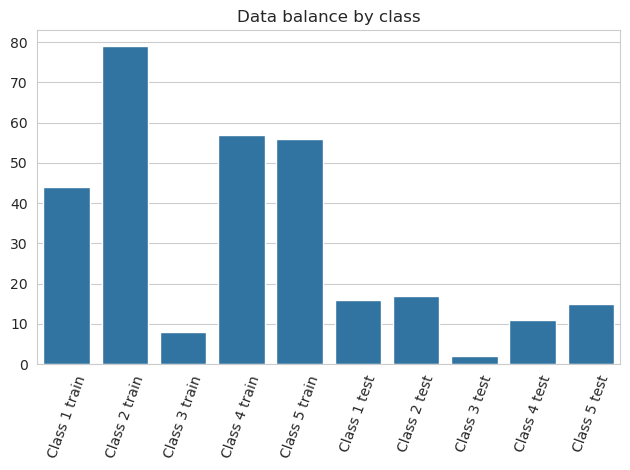

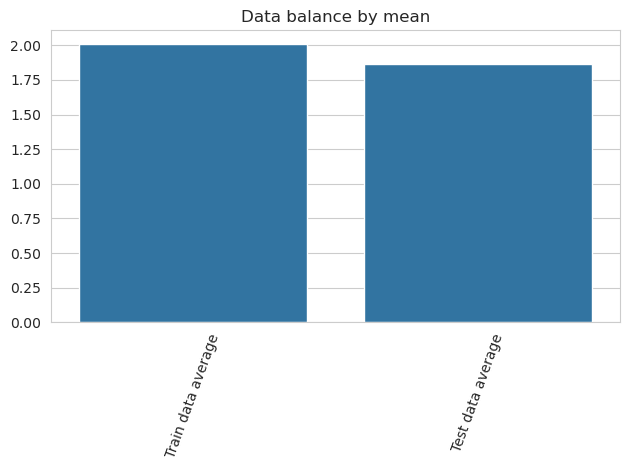

In [29]:
visualize_holdout_balance(train_dl, test_dl)

#### MLP Model 1

In [30]:
EPOCHS = 200
LEARNING_RATE = 0.001

In [31]:
from torch.nn import Module, Linear, ReLU, Softmax, Sigmoid
from torch.nn.init import xavier_uniform_, kaiming_uniform_

class MLP_1(Module):
    def __init__(self, n_inputs):
        super(MLP_1, self).__init__()
        self.hidden1 = Linear(n_inputs, 1000)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(1000, 500)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(500, 5)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [32]:
model = MLP_1(2013)

In [33]:
from torchinfo import summary

print(summary(model, input_size=(len(train_dl.dataset), 2013), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP_1                                    [244, 5]                  --
├─Linear: 1-1                            [244, 1000]               2,014,000
├─ReLU: 1-2                              [244, 1000]               --
├─Linear: 1-3                            [244, 500]                500,500
├─ReLU: 1-4                              [244, 500]                --
├─Linear: 1-5                            [244, 5]                  2,505
├─Softmax: 1-6                           [244, 5]                  --
Total params: 2,517,005
Trainable params: 2,517,005
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 614.15
Input size (MB): 1.96
Forward/backward pass size (MB): 2.94
Params size (MB): 10.07
Estimated Total Size (MB): 14.97


MLP_1(
  (hidden1): Linear(in_features=2013, out_features=1000, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=1000, out_features=500, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=500, out_features=5, bias=True)
  (act3): Softmax(dim=1)
)

In [34]:
from livelossplot import PlotLosses
from torch.nn import CrossEntropyLoss, MSELoss
from torch.optim import SGD, Adam

# Função para treinar o modelo
def train_model(train_dl, val_dl, model):
    # Cria um objeto PlotLosses para visualização em tempo real das métricas
    liveloss = PlotLosses()
    
    # Define a função de perda para problemas de classificação
    criterion = CrossEntropyLoss()
    # Define o otimizador como SGD com taxa de aprendizado e momentum
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    # Loop pelas épocas de treinamento
    for epoch in range(EPOCHS):
        # Dicionário para armazenar as métricas de cada época
        logs = {}
        
        # Coloca o modelo em modo de treinamento
        model.train()
        # Inicializa variáveis acumuladoras para perda e acertos
        running_loss = 0.0
        running_corrects = 0.0
        
        model = model.to(torch.float32)
        # Loop pelos lotes no conjunto de dados de treino
        for inputs, labels in train_dl:
            # Move os dados para o dispositivo especificado (CPU ou GPU)
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            
            # Calcula as previsões do modelo para o lote atual
            outputs = model(inputs)
            # Calcula a perda entre as previsões e os rótulos verdadeiros
            loss = criterion(outputs, labels)
            # Zera os gradientes dos parâmetros antes do retropropagação
            optimizer.zero_grad()
            
            # Calcula os gradientes dos parâmetros do modelo
            loss.backward()
            # Atualiza os parâmetros do modelo com base nos gradientes
            optimizer.step()
            
            # Acumula a perda para calcular a média no final
            running_loss += loss.detach() * inputs.size(0)
            # Obtém as previsões mais prováveis para calcular a acurácia
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        # Calcula a perda média e a acurácia para a época de treino
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        # Adiciona as métricas de treino ao dicionário logs
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()

        # Coloca o modelo em modo de avaliação (sem ajuste de pesos)
        model.eval()
        # Reinicializa acumuladores para a avaliação
        running_loss = 0.0
        running_corrects = 0.0


        model = model.to(torch.float32)
        # Loop pelos lotes no conjunto de dados de validação
        for inputs, labels in val_dl:
            # Move os dados para o dispositivo especificado (CPU ou GPU)
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            
            # Calcula as previsões do modelo para o lote de validação
            outputs = model(inputs)
            # Calcula a perda entre as previsões e os rótulos verdadeiros
            loss = criterion(outputs, labels)
            # Acumula a perda para calcular a média no final
            running_loss += loss.detach() * inputs.size(0)
            # Obtém as previsões mais prováveis para calcular a acurácia
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        # Calcula a perda média e a acurácia para a época de validação
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        # Adiciona as métricas de validação ao dicionário logs
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()   
        
        # Atualiza o gráfico de métricas com os dados de logs
        liveloss.update(logs)
        # Exibe as métricas atualizadas
        liveloss.send()


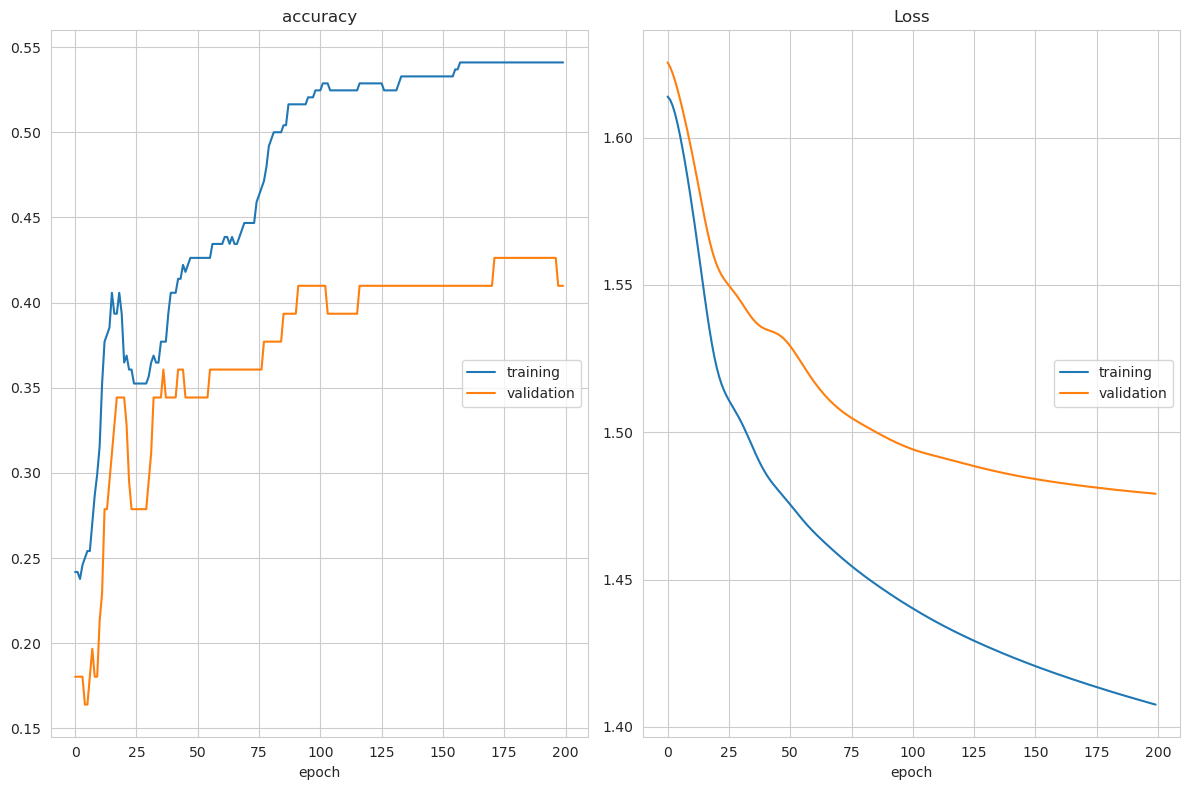

accuracy
	training         	 (min:    0.238, max:    0.541, cur:    0.541)
	validation       	 (min:    0.164, max:    0.426, cur:    0.410)
Loss
	training         	 (min:    1.408, max:    1.614, cur:    1.408)
	validation       	 (min:    1.479, max:    1.626, cur:    1.479)


In [35]:
train_model(train_dl, test_dl, model)

In [36]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values

predictions, actual_values = evaluate_model(test_dl, model)

In [37]:
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm, annot=True, xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],
                yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], 
                annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

In [38]:
success = 0
failure = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r+1} prediction:{p+1}') 
    if r==p: success+=1  
    else: failure+=1

real:[3] prediction:[4]
real:[4] prediction:[4]
real:[5] prediction:[4]
real:[4] prediction:[2]
real:[2] prediction:[2]
real:[5] prediction:[4]
real:[2] prediction:[2]
real:[1] prediction:[1]
real:[5] prediction:[2]
real:[1] prediction:[4]
real:[2] prediction:[2]
real:[3] prediction:[2]
real:[4] prediction:[1]
real:[2] prediction:[2]
real:[5] prediction:[2]
real:[4] prediction:[4]
real:[5] prediction:[1]
real:[2] prediction:[2]
real:[2] prediction:[4]
real:[1] prediction:[1]
real:[1] prediction:[4]
real:[1] prediction:[2]
real:[2] prediction:[2]
real:[2] prediction:[2]
real:[2] prediction:[2]
real:[1] prediction:[1]
real:[1] prediction:[4]
real:[5] prediction:[2]
real:[1] prediction:[4]
real:[2] prediction:[2]
real:[4] prediction:[2]
real:[4] prediction:[4]
real:[5] prediction:[2]
real:[5] prediction:[2]
real:[1] prediction:[4]
real:[1] prediction:[4]
real:[5] prediction:[4]
real:[1] prediction:[4]
real:[4] prediction:[4]
real:[1] prediction:[1]
real:[1] prediction:[4]
real:[4] predict

In [39]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'success:{success} failure:{failure}')

Accuracy: 0.410

success:25 failure:36


              precision    recall  f1-score   support

           0       0.50      0.25      0.33        16
           1       0.52      0.88      0.65        17
           2       0.00      0.00      0.00         2
           3       0.25      0.55      0.34        11
           4       0.00      0.00      0.00        15

    accuracy                           0.41        61
   macro avg       0.25      0.34      0.27        61
weighted avg       0.32      0.41      0.33        61

[[ 4  2  0 10  0]
 [ 0 15  0  2  0]
 [ 0  1  0  1  0]
 [ 2  3  0  6  0]
 [ 2  8  0  5  0]]


/home/eduardoascunha/miniconda3/envs/envNAME/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eduardoascunha/miniconda3/envs/envNAME/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eduardoascunha/miniconda3/envs/envNAME/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

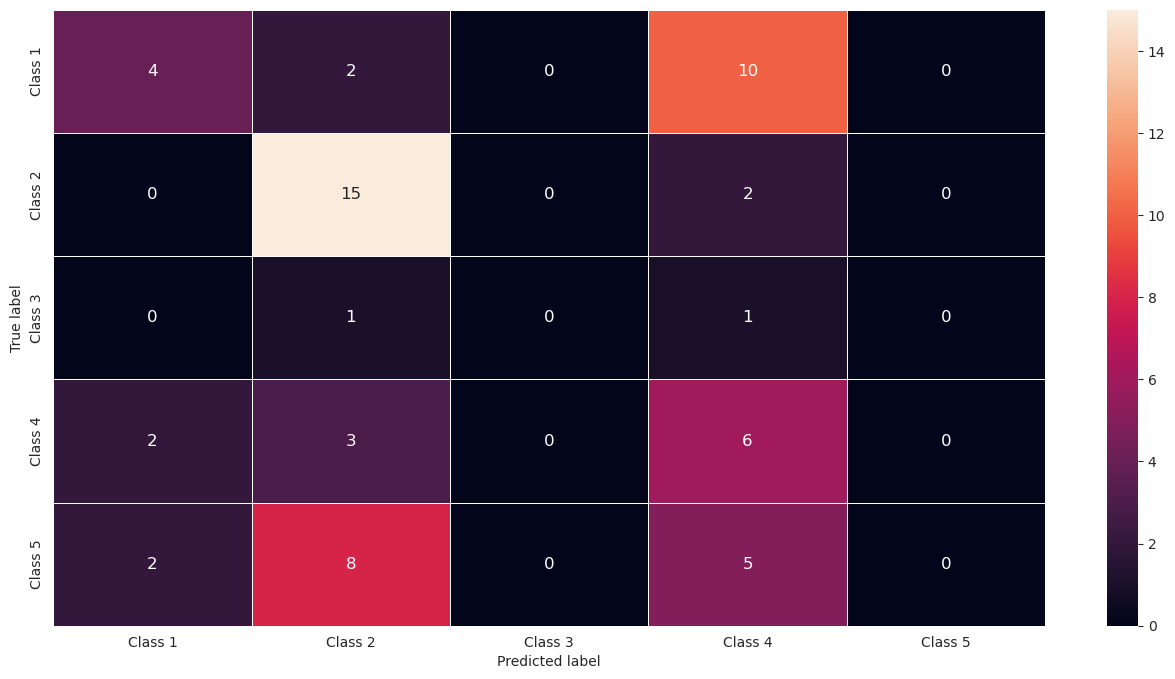

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(actual_values, predictions))
cm = confusion_matrix(actual_values, predictions)
print(cm)
display_confusion_matrix(cm)

# CSV

In [41]:
df = pd.read_csv("../sbsppdaa24/test_radiomics_hipocamp.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2180 entries, ID to Age
dtypes: float64(2011), int64(150), object(19)
memory usage: 1.7+ MB


In [42]:
# Drop unique identifier columns
df.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Drop non-numeric columns except for 'Transition'
columns_to_drop = [col for col in df.columns if df[col].dtype == 'object' and col != 'Transition']
df.drop(columns=columns_to_drop, inplace=True)

# Apply MinMax scaling to columns
from sklearn.preprocessing import MinMaxScaler
float_cols = df.select_dtypes(include=['float', 'int']).columns
scaler = MinMaxScaler()
df[float_cols] = scaler.fit_transform(df[float_cols])

In [43]:
df = df.loc[:, df.nunique() > 1]

In [44]:
# Converta o dataframe para tensor do PyTorch
test_X = torch.tensor(df.values, dtype=torch.float32, device=device)


In [45]:
# Coloque o modelo em modo de avaliação
model.eval()

# Gere previsões
with torch.no_grad():
    predictions = model(test_X)

# Pegue as classes com maior probabilidade
predicted_classes = torch.argmax(predictions, dim=1)

In [46]:
# Obter as previsões decodificadas
predictions_decoded = le.inverse_transform(predicted_classes.cpu().numpy())

# Criar o DataFrame para salvar no CSV
res = pd.DataFrame({
    'RowId': range(1, len(predictions_decoded) + 1),  # Garante que o RowId começa de 1
    'Result': predictions_decoded  # Previsões decodificadas para as classes
})

# Salvar no arquivo CSV
res.to_csv("nn_predictions.csv", index=False, encoding='utf-8')